## **Fine-Tuning Embedding Models for Tabular RAG**
*By Cristian Leo*

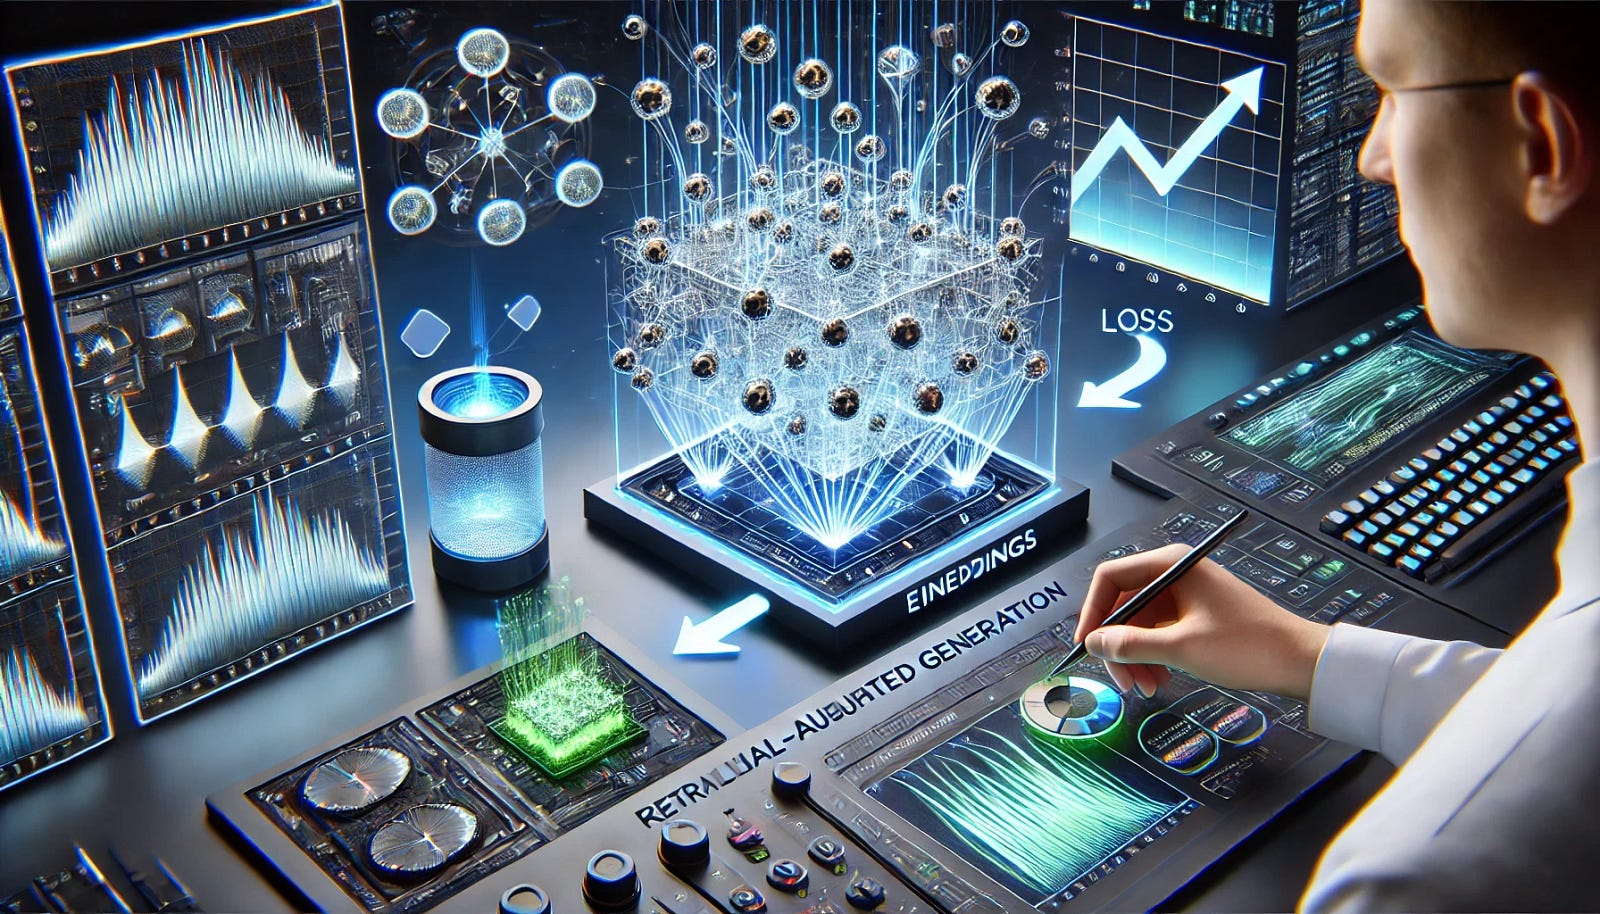

In [1]:
# Standard library imports
import logging
import os
import pickle
import re
import time
from dataclasses import dataclass, field
from typing import Any, Dict, List, Union

# Data science and ML libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import yfinance as yf
from sentence_transformers import InputExample, SentenceTransformer, losses
import faiss
from sklearn.metrics.pairwise import cosine_similarity

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# LangChain related
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.rate_limiters import InMemoryRateLimiter

from langchain_core.prompts import PromptTemplate
# Other third-party libraries
from dotenv import load_dotenv
from tqdm import tqdm

load_dotenv()


os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")



logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

load_dotenv()

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [2]:
# ---------------------------
# 1. Configuration Classes
# ---------------------------
@dataclass
class Config:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    embedding_model: str = "all-MiniLM-L6-v2"
    top_k: int = 1

In [3]:
# ---------------------------
# 2. Data Loading: Quarterly Balance Sheets
# ---------------------------
class FinancialDataLoader:
    """
    Class to load financial data from Yahoo Finance

    Args:
    -----
    config: Config
        Configuration object with the desired tickers
    """
    def __init__(self, config: Config):
        self.config = config
        self.logger = logging.getLogger(__name__)

    def load_quarterly_balance_sheets(self) -> Dict[str, pd.DataFrame]:
        """
        Load quarterly balance sheets for the specified tickers

        Returns:
        --------
        Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        """
        balance_sheets = {}
        #for ticker in self.config.tickers:
        #    print(f"IM HERE {ticker}")
        for ticker in tqdm(
            self.config.tickers, desc="Loading quarterly balance sheets"
        ):
            try:
                print(f"IM HERE {ticker}")
                stock = yf.Ticker(ticker)
                print(f"STOCK {stock}")
                # Using the quarterly balance sheet property from yfinance
                bs = stock.quarterly_balance_sheet
                print(f"BS {bs}")
                bs.dropna(axis=1, thresh=0.5, inplace=True)
                bs.dropna(axis=0, thresh=0.5, inplace=True)
                if bs is not None and not bs.empty:
                    # (Transpose so that each row is one quarter if desired)
                    balance_sheets[ticker] = bs.T
                    self.logger.info(
                        f"Successfully loaded quarterly balance sheet for {ticker}"
                    )
            except Exception as e:
                self.logger.error(
                    f"Error loading quarterly balance sheet for {ticker}: {e}"
                )
        return balance_sheets

In [4]:
# ---------------------------
# 3. Financial Chunker & Balance Sheet Visualization
# ---------------------------
class FinancialChunker:
    """
    Class to create text chunks from financial data

    Args:
    -----
    model_name: str
        Name of the SentenceTransformer model to use
    """
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.embedder = SentenceTransformer(model_name)

    def create_chunks(self, balance_sheets: Dict[str, pd.DataFrame]) -> List[str]:
        """
        For each ticker and for each quarter in its balance sheet, create a text chunk.

        Args:
        -----
        balance_sheets: Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        
        Returns:
        --------
        List[str]
            List of text chunks
        """
        chunks = []
        for ticker, df in balance_sheets.items():
            # Each row corresponds to one quarter (with the date as index)
            for date, row in df.iterrows():
                # Select a few key metrics if available (or iterate over all)
                total_assets = row.get("Total Assets", None)
                total_liabilities = row.get("Total Liab", None) or row.get(
                    "Total Liabilities", None
                )
                total_equity = row.get("Total Stockholder Equity", None) or row.get(
                    "Total Equity", None
                )

                # Build a summary text for the quarter.
                text = f"{ticker} Balance Sheet as of {date.strftime('%Y-%m-%d')}:\n"
                if total_assets is not None:
                    text += f"- Total Assets: {total_assets:,.0f}\n"
                if total_liabilities is not None:
                    text += f"- Total Liabilities: {total_liabilities:,.0f}\n"
                if total_equity is not None:
                    text += f"- Total Equity: {total_equity:,.0f}\n"
                # Optionally include additional metrics
                for metric, value in row.items():
                    if metric not in [
                        "Total Assets",
                        "Total Liab",
                        "Total Liabilities",
                        "Total Stockholder Equity",
                        "Total Equity",
                    ]:
                        text += f"- {metric}: {value}\n"
                chunks.append(text)
        return chunks

In [5]:
# ---------------------------
# 4. Vector Store & RAG System
# ---------------------------
class VectorStore:
    """
    Class to create a vector store and search for similar vectors

    Args:
    -----
    config: Config
        Configuration object with the desired embedding model
    """
    def __init__(self, config: Config):
        self.config = config
        self.model = SentenceTransformer(config.embedding_model)
        self.index = None
        self.chunks = []

    def create_index(self, chunks: List[str]) -> None:
        """
        Create a Faiss index for the embeddings of the text chunks

        Args:
        -----
        chunks: List[str]
            List of text chunks
        """
        embeddings = self.model.encode(chunks)
        print(f"embeddings shape {embeddings.shape}")
        dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(dimension)
        self.index.add(np.array(embeddings).astype("float32"))
        self.chunks = chunks

    def search(self, query: str) -> List[str]:
        """
        Search for similar text chunks given a query

        Args:
        -----
        query: str
            Query text
        
        Returns:
        --------
        List[str]
            List of similar text chunks
        """
        query_embedding = self.model.encode([query])
        D, I = self.index.search(
            np.array(query_embedding).astype("float32"), self.config.top_k
        )
        return [self.chunks[i] for i in I[0]]
    
class FinancialRAG:
    """
    Class to initialize and query the RAG system

    Args:
    -----
    config: Config
        Configuration object with the desired settings
    """
    def __init__(self, config: Config):
        self.config = config
        self.loader = FinancialDataLoader(self.config)
        self.chunker = FinancialChunker(model_name=self.config.embedding_model)
        self.vector_store = VectorStore(self.config)
        self.logger = logging.getLogger(__name__)

    def initialize(self):
        """
        Initialize the RAG system by loading financial data, creating text chunks and building the vector store
        """
        balance_sheets = self.loader.load_quarterly_balance_sheets()
        #print(f"BALANCE SHEETS {balance_sheets.keys()}")
        chunks = self.chunker.create_chunks(balance_sheets)
        self.vector_store.create_index(chunks)
        self.logger.info("RAG system initialized successfully")

    def query(self, question: str) -> List[str]:
        """
        Query the RAG system with a question

        Args:
        -----
        question: str
            Question text
        
        Returns:
        --------
        List[str]
            List of similar text chunks
        """
        return self.vector_store.search(question)

In [6]:
# ---------------------------
# 5. Fine-Tuning the Embedding Model using Quarterly Balance Sheets
# ---------------------------
@dataclass
class TrainConfig:
    tickers: List[str] = field(
        default_factory=lambda: ["AAPL", "GOOGL", "MSFT", "AMZN", "META"]
    )
    epochs: int = 1000
    batch_size: int = 16
    learning_rate: float = 2e-5
    epsilon: float = 1e-6
    scheduler: str = "WarmupLinear"
    optimizer_class: Any = torch.optim.AdamW
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    model_output_dir: str = "fine-tuned-embedding-model"


def generate_questions(context: str) -> str:
    """
    Uses LangChain's Gemini to generate a set of insightful questions
    for a given quarterly balance sheet summary.

    Args:
    -----
    context: str
        The quarterly balance sheet summary

    Returns:
    --------
    str
        The generated question
    """
    rate_limiter = InMemoryRateLimiter(requests_per_second=0.1)

    llm = GoogleGenerativeAI(
        model="gemini-3-flash-preview",
        api_key=os.getenv("GOOGLE_API_KEY"),
        rate_limiter=rate_limiter,
    )

    prompt = PromptTemplate(
        template="Generate one insightful question targeted for retrieval purposes about the following quarterly balance sheet summary:\n\n{context}\n\nQuestions:",
        input_variables=["context"],
    )
    chain = prompt | llm
    response = chain.invoke({"context": context})

    # Use regex to extract only the final question if any extra text exists.
    match = re.search(
        r"(?:Final Question:)(.*)", response, flags=re.IGNORECASE | re.DOTALL
    )
    if match:
        question = match.group(1).strip()
    else:
        question = response.strip()

    # remove any stray chain-of-thought markers.
    question = re.sub(r"<think>.*?</think>", "", question, flags=re.DOTALL).strip()
    return question

In [7]:
# ---------------------------
# 6. Model Training & Evaluation
# ---------------------------
class FinancialDataset:
    """
    Creates training examples using the balance sheet chunks generated by the chunker.
    For each chunk, a set of questions is generated using LangChain Ollama.
    A fraction of the generated examples is held out as a test dataset.
    """

    def __init__(
        self, balance_sheets: Dict[str, pd.DataFrame], chunker: FinancialChunker
    ):
        self.examples = []  # Training examples

        # check if pickle file exists
        if os.path.exists("qa_pairs.pkl"):
            print("Loading examples from pickle file")
            self.load_examples()
        else:
            self._create_examples(balance_sheets, chunker)

    def _create_examples(
        self, balance_sheets: List[dict], chunker: FinancialChunker
    ) -> None:
        """
        Create training and test examples from balance sheets.

        Args:
            balance_sheets: List of balance sheet dictionaries
            chunker: Chunker instance to split text
        """
        logging.info(f"Creating examples from {len(balance_sheets)} balance sheets")

        # Create chunks
        chunks = chunker.create_chunks(balance_sheets)
        all_examples: List[InputExample] = []

        # Generate questions for each chunk with progress bar
        for chunk in tqdm(
            chunks, desc="Generating questions", unit="chunk", leave=True, position=0
        ):
            try:
                question = generate_questions(chunk)
                time.sleep(3)  # Rate limit to avoid API restrictions
                all_examples.append(InputExample(texts=[chunk, question]))
            except Exception as e:
                logging.error(f"Failed to generate question for chunk: {e}")
                continue

        self.examples = all_examples
        self.save_examples()

        logging.info(f"Created {len(self.examples)} examples")

    # save examples as pickle
    def save_examples(self):
        with open("qa_pairs.pkl", "wb") as f:
            pickle.dump(self.examples, f)

    # load examples from pickle
    def load_examples(self):
        with open("qa_pairs.pkl", "rb") as f:
            self.examples = pickle.load(f)

In [8]:
# ---------------------------
# 7. Model Training
# ---------------------------
class ModelTrainer:
    """
    Class to train a SentenceTransformer model on financial data

    Args:
    -----
    config: TrainConfig
        Configuration object with the desired settings
    """
    def __init__(self, config: TrainConfig):
        self.config = config
        self.model = None
        self.model_output_dir = self.config.model_output_dir
        self.logger = logging.getLogger(__name__)

    def model_exists(self):
        return os.path.exists(self.model_output_dir)

    def load_model(self):
        if self.model_exists():
            self.model = SentenceTransformer(self.model_output_dir)
            self.logger.info(f"Loaded fine-tuned model from {self.model_output_dir}")
            return self.model
        return None

    def save_model(self):
        if self.model:
            self.model.save(self.model_output_dir)
            self.logger.info(f"Saved fine-tuned model to {self.model_output_dir}")

    def train(self, balance_sheets: Dict[str, pd.DataFrame]) -> SentenceTransformer:
        """
        Train a SentenceTransformer model on financial data
        
        Args:
        -----
        balance_sheets: Dict[str, pd.DataFrame]
            Dictionary with the quarterly balance sheets for each ticker
        
        Returns:
        --------
        SentenceTransformer
            Trained SentenceTransformer model
        """
        if self.load_model():
            self.model = self.model
        else:
            self.model = SentenceTransformer(self.config.model_name)
        print("Marco")
        dataset = FinancialDataset(balance_sheets, FinancialChunker())
        print("Polo")
        dataloader = DataLoader(
            dataset.examples, batch_size=self.config.batch_size, shuffle=False
        )
        loss = losses.MultipleNegativesRankingLoss(self.model)

        self.model.fit(
            train_objectives=[(dataloader, loss)],
            epochs=self.config.epochs,
            scheduler=self.config.scheduler,
            optimizer_class=self.config.optimizer_class,
            optimizer_params={
                "lr": self.config.learning_rate,
                "eps": self.config.epsilon,
            },
            show_progress_bar=True,
        )

        self.save_model()
        return self.model

In [9]:
# ---------------------------
# 8. Model Evaluation
# ---------------------------
@dataclass
class EvaluationResult:
    query: str
    pre_contexts: List[str]
    post_contexts: List[str]
    pre_similarity: float
    post_similarity: float
    improvement: float


class EmbeddingEvaluator:
    """
    Class to evaluate the performance of the fine-tuned embedding model

    Args:
    -----
    rag_pre: FinancialRAG
        RAG system with the pre-trained model
    rag_post: FinancialRAG
        RAG system with the fine-tuned model
    queries: List[str]
        List of queries to evaluate
    """
    def __init__(
        self, rag_pre: FinancialRAG, rag_post: FinancialRAG, queries: List[Any]
    ):
        self.rag_pre = rag_pre
        self.rag_post = rag_post
        self.test_queries = queries
        self.results = []

    def evaluate(self) -> List[EvaluationResult]:
        """
        Evaluate the performance of the fine-tuned model

        Returns:
        --------
        List[EvaluationResult]
            List of evaluation results
        """
        for query in self.test_queries:
            query = query.texts[1]
            pre_contexts = self.rag_pre.query(query)
            post_contexts = self.rag_post.query(query)
            if any([not pre_contexts, not post_contexts]):
                continue
            pre_context = pre_contexts[0]
            post_context = post_contexts[0]
            # Encode the query and its retrieved top context
            pre_query_emb = self.rag_pre.vector_store.model.encode(
                [query], show_progress_bar=False
            )
            pre_context_emb = self.rag_pre.vector_store.model.encode(
                [pre_context], show_progress_bar=False
            )
            post_query_emb = self.rag_post.vector_store.model.encode(
                [query], show_progress_bar=False
            )
            post_context_emb = self.rag_post.vector_store.model.encode(
                [post_context], show_progress_bar=False
            )
            pre_sim = cosine_similarity(pre_query_emb, pre_context_emb)[0][0]
            post_sim = cosine_similarity(post_query_emb, post_context_emb)[0][0]
            self.results.append(
                EvaluationResult(
                    query=query,
                    pre_contexts=[pre_context],
                    post_contexts=[post_context],
                    pre_similarity=pre_sim,
                    post_similarity=post_sim,
                    improvement=post_sim - pre_sim,
                )
            )

    def visualize_results(self):
        improvements = [r.improvement for r in self.results]
        queries = [r.query for r in self.results]
        plt.figure(figsize=(10, 6))
        sns.barplot(x=improvements, y=queries)
        plt.title("Embedding Performance Improvement")
        plt.xlabel("Improvement Score")
        plt.tight_layout()
        plt.savefig("embedding_comparison.png")
        return self.results

In [10]:
# ---------------------------
# 9. Running the Exercise
# ---------------------------
# Initialize RAG system with pre-trained model using quarterly balance sheets
rag_pre = FinancialRAG(config=Config())

rag_pre.initialize()
print("Im here!!!")
# Load quarterly balance sheets for training and visualization
loader = FinancialDataLoader(Config())
quarterly_balance_sheets = loader.load_quarterly_balance_sheets()
quarterly_balance_sheets["AAPL"].head()

2025-12-30 20:17:12,948 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:17:12,949 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-12-30 20:17:14,191 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:17:14,191 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
Loading quarterly balance sheets:   0%|                                                                                                                      | 0/5 [00:00<?, ?it/s]

IM HERE AAPL
STOCK yfinance.Ticker object <AAPL>


2025-12-30 20:17:15,555 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
Loading quarterly balance sheets:  20%|██████████████████████                                                                                        | 1/5 [00:00<00:01,  2.00it/s]

BS                                                     2025-09-30    2025-06-30  \
Ordinary Shares Number                            1.477326e+10  1.485672e+10   
Share Issued                                      1.477326e+10  1.485672e+10   
Net Debt                                          6.272300e+10  6.542900e+10   
Total Debt                                        9.865700e+10  1.016980e+11   
Tangible Book Value                               7.373300e+10  6.583000e+10   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  5.469700e+10  5.537200e+10   
Other Short Term Investments                      1.876300e+10  1.910300e+10   
Cash And Cash Equivalents                         3.593400e+10  3.626900e+10   
Cash Equivalents                                  7.667000e+09  9.583000e+09   
Cash Financial                                    2.826700e+10  2.668600e+10   

                                    

2025-12-30 20:17:15,771 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
Loading quarterly balance sheets:  40%|████████████████████████████████████████████                                                                  | 2/5 [00:00<00:00,  3.01it/s]

IM HERE MSFT
STOCK yfinance.Ticker object <MSFT>


2025-12-30 20:17:16,007 - __main__ - INFO - Successfully loaded quarterly balance sheet for MSFT
Loading quarterly balance sheets:  60%|██████████████████████████████████████████████████████████████████                                            | 3/5 [00:00<00:00,  3.47it/s]

BS                                                     2025-09-30    2025-06-30  \
Ordinary Shares Number                            7.433088e+09  7.434000e+09   
Share Issued                                      7.433088e+09  7.434000e+09   
Net Debt                                          1.435900e+10  1.290900e+10   
Total Debt                                        6.055600e+10  6.058800e+10   
Tangible Book Value                               2.223430e+11  2.013660e+11   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  1.020050e+11  9.455500e+10   
Other Short Term Investments                      7.315600e+10  6.431300e+10   
Cash And Cash Equivalents                         2.884900e+10  3.024200e+10   
Cash Equivalents                                  1.748300e+10  1.853100e+10   
Cash Financial                                    1.136600e+10  1.171100e+10   

                                    

2025-12-30 20:17:16,238 - __main__ - INFO - Successfully loaded quarterly balance sheet for AMZN
Loading quarterly balance sheets:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 4/5 [00:01<00:00,  3.76it/s]

IM HERE META
STOCK yfinance.Ticker object <META>


2025-12-30 20:17:16,493 - __main__ - INFO - Successfully loaded quarterly balance sheet for META
Loading quarterly balance sheets: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.48it/s]

BS                                                     2025-09-30    2025-06-30  \
Ordinary Shares Number                            2.521179e+09  2.516000e+09   
Share Issued                                      2.521179e+09  2.516000e+09   
Net Debt                                          1.864700e+10  1.682700e+10   
Total Debt                                        5.106000e+10  4.956000e+10   
Tangible Book Value                               1.729080e+11  1.744160e+11   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  4.444800e+10  4.707100e+10   
Other Short Term Investments                      3.426100e+10  3.506600e+10   
Cash And Cash Equivalents                         1.018700e+10  1.200500e+10   
Cash Equivalents                                  6.023000e+09  7.261000e+09   
Cash Financial                                    4.164000e+09  4.744000e+09   

                                    

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-30 20:17:16,870 - __main__ - INFO - RAG system initialized successfully


embeddings shape (29, 384)
Im here!!!


Loading quarterly balance sheets:   0%|                                                                                                                      | 0/5 [00:00<?, ?it/s]2025-12-30 20:17:16,884 - __main__ - INFO - Successfully loaded quarterly balance sheet for AAPL
2025-12-30 20:17:16,898 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-12-30 20:17:16,910 - __main__ - INFO - Successfully loaded quarterly balance sheet for MSFT
2025-12-30 20:17:16,923 - __main__ - INFO - Successfully loaded quarterly balance sheet for AMZN
2025-12-30 20:17:16,934 - __main__ - INFO - Successfully loaded quarterly balance sheet for META
Loading quarterly balance sheets: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.27it/s]

IM HERE AAPL
STOCK yfinance.Ticker object <AAPL>
BS                                                     2025-09-30    2025-06-30  \
Ordinary Shares Number                            1.477326e+10  1.485672e+10   
Share Issued                                      1.477326e+10  1.485672e+10   
Net Debt                                          6.272300e+10  6.542900e+10   
Total Debt                                        9.865700e+10  1.016980e+11   
Tangible Book Value                               7.373300e+10  6.583000e+10   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  5.469700e+10  5.537200e+10   
Other Short Term Investments                      1.876300e+10  1.910300e+10   
Cash And Cash Equivalents                         3.593400e+10  3.626900e+10   
Cash Equivalents                                  7.667000e+09  9.583000e+09   
Cash Financial                                    2.826700e+10  2.66

Ordinary Shares Number  Share Issued      Net Debt    Total Debt  \
2025-09-30            1.477326e+10  1.477326e+10  6.272300e+10  9.865700e+10   
2025-06-30            1.485672e+10  1.485672e+10  6.542900e+10  1.016980e+11   
2025-03-31            1.493932e+10  1.493932e+10  7.002400e+10  9.818600e+10   
2024-12-31            1.503787e+10  1.503787e+10  6.650000e+10  9.679900e+10   
2024-09-30            1.511679e+10  1.511679e+10  7.668600e+10  1.066290e+11   

            Tangible Book Value  Invested Capital  Working Capital  \
2025-09-30         7.373300e+10      1.723900e+11    -1.767400e+10   
2025-06-30         6.583000e+10      1.675280e+11    -1.862900e+10   
2025-03-31         6.679600e+10      1.649820e+11    -2.589700e+10   
2024-12-31         6.675800e+10      1.635570e+11    -1.112500e+10   
2024-09-30         5.695000e+10      1.635790e+11    -2.340500e+10   

            Net Tangible Assets  Common Stock Equity  Total Capitalization  \
2025-09-30         7.373300e+10         7.373300e+10          1.520610e+11   
2025-06-30         6.583000e+10         6.583000e+10          1.482600e+11   
2025-03-31         6.679600e+10         6.679600e+10          1.453620e+11   
2024-12-31         6.675800e+10         6.675800e+10          1.507140e+11   
2024-09-30         5.695000e+10         5.695000e+10          1.427000e+11   

            ...  Finished Goods  Raw Materials   Receivables  \
2025-09-30  ...             NaN            NaN  7.295700e+10   
2025-06-30  ...    3.637000e+09   2.288000e+09  4.683500e+10   
2025-03-31  ...    3.596000e+09   2.673000e+09  4.979800e+10   
2024-12-31  ...    4.119000e+09   2.792000e+09  5.930600e+10   
2024-09-30  ...             NaN            NaN  6.624300e+10   

            Other Receivables  Accounts Receivable  \
2025-09-30       3.318000e+10         3.977700e+10   
2025-06-30       1.927800e+10         2.755700e+10   
2025-03-31       2.366200e+10         2.613600e+10   
2024-12-31       2.966700e+10         2.963900e+10   
2024-09-30       3.283300e+10         3.341000e+10   

            Cash Cash Equivalents And Short Term Investments  \
2025-09-30                                      5.469700e+10   
2025-06-30                                      5.537200e+10   
2025-03-31                                      4.849800e+10   
2024-12-31                                      5.377500e+10   
2024-09-30                                      6.517100e+10   

            Other Short Term Investments  Cash And Cash Equivalents  \
2025-09-30                  1.876300e+10               3.593400e+10   
2025-06-30                  1.910300e+10               3.626900e+10   
2025-03-31                  2.033600e+10               2.816200e+10   
2024-12-31                  2.347600e+10               3.029900e+10   
2024-09-30                  3.522800e+10               2.994300e+10   

            Cash Equivalents  Cash Financial  
2025-09-30      7.667000e+09    2.826700e+10  
2025-06-30      9.583000e+09    2.668600e+10  
2025-03-31      3.101000e+09    2.506100e+10  
2024-12-31      3.226000e+09    2.707300e+10  
2024-09-30      2.744000e+09    2.719900e+10  

[5 rows x 65 columns]

In [11]:
# Fine tune the embedding model on quarterly balance sheet examples
train_config = TrainConfig()


In [12]:
print("IM HERE 1")
trainer = ModelTrainer(train_config)
print("IM HERE 2")

fine_tuned_model = trainer.train(quarterly_balance_sheets)

# Use the fine-tuned model in a new RAG system
rag_post = FinancialRAG(config=Config(embedding_model=train_config.model_output_dir))
rag_post.vector_store.model = fine_tuned_model  # Update the embedding model
rag_post.initialize()

2025-12-30 20:17:29,258 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:17:29,260 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model


IM HERE 1
IM HERE 2


2025-12-30 20:17:29,660 - __main__ - INFO - Loaded fine-tuned model from fine-tuned-embedding-model
2025-12-30 20:17:29,662 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:17:29,662 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Marco


2025-12-30 20:17:30,449 - root - INFO - Creating examples from 5 balance sheets
Generating questions:   0%|                                                                                                                              | 0/29 [00:00<?, ?chunk/s]2025-12-30 20:17:30,456 - langchain_google_genai.llms - WARNING - Unexpected argument 'rate_limiter' provided to GoogleGenerativeAI.
2025-12-30 20:17:30,699 - google_genai.models - INFO - AFC is enabled with max remote calls: 10.
2025-12-30 20:17:41,022 - httpx - INFO - HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/models/gemini-3-flash-preview:generateContent "HTTP/1.1 200 OK"
Generating questions:   3%|████                                                                                                                  | 1/29 [00:13<06:20, 13.58s/chunk]2025-12-30 20:17:44,042 - langchain_google_genai.llms - WARNING - Unexpected argument 'rate_limiter' provided to GoogleGenerativeAI.
2025-12-30 20:17:44,114 - 

Polo


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/opt/homebrew/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


2025-12-30 20:41:05,832 - sentence_transformers.SentenceTransformer - INFO - Save model to fine-tuned-embedding-model
2025-12-30 20:41:07,127 - __main__ - INFO - Saved fine-tuned model to fine-tuned-embedding-model
2025-12-30 20:41:07,152 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:41:07,153 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
2025-12-30 20:41:07,380 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-12-30 20:41:07,380 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: fine-tuned-embedding-model
Loading quarterly balance sheets:  20%|██████████████████████                                                                                        | 1/5 [00:00<00:00,  9.90it/s]2025-12-30 20:41:07,606 - __main__ - INFO - Successfully loaded quarterly balance sheet for GOOGL
2025-12-30 20:

IM HERE AAPL
STOCK yfinance.Ticker object <AAPL>
BS                                                     2025-09-30    2025-06-30  \
Ordinary Shares Number                            1.477326e+10  1.485672e+10   
Share Issued                                      1.477326e+10  1.485672e+10   
Net Debt                                          6.272300e+10  6.542900e+10   
Total Debt                                        9.865700e+10  1.016980e+11   
Tangible Book Value                               7.373300e+10  6.583000e+10   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  5.469700e+10  5.537200e+10   
Other Short Term Investments                      1.876300e+10  1.910300e+10   
Cash And Cash Equivalents                         3.593400e+10  3.626900e+10   
Cash Equivalents                                  7.667000e+09  9.583000e+09   
Cash Financial                                    2.826700e+10  2.66

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-30 20:41:08,147 - __main__ - INFO - RAG system initialized successfully


embeddings shape (29, 384)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/7g/spzg5y6978b38x5hcb0xhbfw0000gn/T/ipykernel_46762/2715789501.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


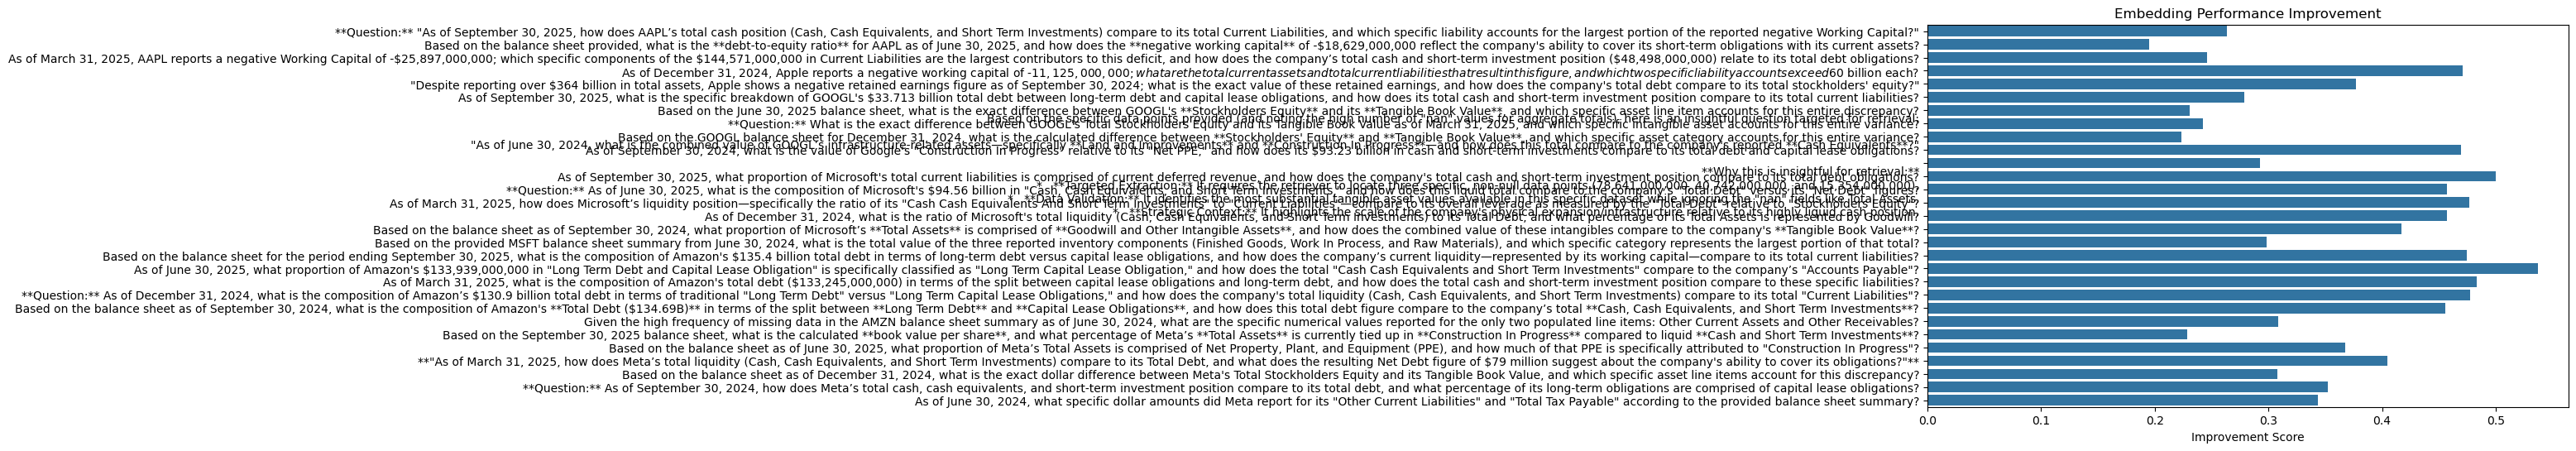

In [14]:

# Load QA pairs
with open("qa_pairs.pkl", "rb") as f:
    examples = pickle.load(f)

evaluator = EmbeddingEvaluator(rag_pre=rag_pre, rag_post=rag_post, queries=examples)
evaluator.evaluate()
results = evaluator.visualize_results()

In [15]:
pre_tuning_similarities = [r.pre_similarity for r in results]
post_tuning_similarities = [r.post_similarity for r in results]
improvements = [r.improvement for r in results]

# Print statistics
print(f"Average Pre-Tuning Similarity: {np.mean(pre_tuning_similarities):.3f}")
print(f"Average Post-Tuning Similarity: {np.mean(post_tuning_similarities):.3f}")
print(f"Average Improvement: {np.mean(improvements):.3f}")

Average Pre-Tuning Similarity: 0.564
Average Post-Tuning Similarity: 0.931
Average Improvement: 0.367
